In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [2]:
# change working directory to the directory of the script
# os.chdir('/home/sendol/catkin_ws/src/turtlebot3_autorace_2020/etc/')

In [3]:
# check current directory
print(os.getcwd())

/home/sendol/catkin_ws/src/turtlebot3_autorace_2020/etc


## 1. Canny Edge Detector로 Edge 찾아내기

이건 지금까지 계속 붙들고 있던 거라 그렇게 자세하게 설명할 필요는 없을 것 같다.

아, 참고로 Canny 이전 단계에 굳이 Gaussian filter를 먹일 필요는 없다. Canny 파이프라인 자체에서 맨 처음 단계로 Gaussian filter를 먹이고 시작한다. 아래 함수에서 apertureSize가 Gaussian filter의 커널 사이즈, 그러니까 블러를 얼마나 많이 먹이고 시작할지를 결정한다.

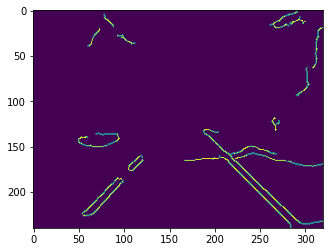

In [38]:
img = cv2.imread('./realworld_rainy.png')
img = cv2.resize(img, (320, 240))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15, 15), 0)
edges = cv2.Canny(gray, 50, 150, apertureSize=3)
plt.imshow(edges)

In [39]:
edges.shape

(240, 320)

## 2. RoI Cropping
전체 이미지에서 차선이 있을 법한 범위만 오려낸다. 추가로 기하학적 변환까지 하는데, 이렇게 하면 '덜 왜곡된' 이미지를 얻을 수 있어 나중에 더 써먹기 편할 것 같다.

사실 아래 함수는 `turtlebot3_autorace_detect/detect_lane`에 있는 걸 가져와서 조금 수정한 거다. 이미지를 binary로 만들기 위해 return 직전의 구문을 추가했고, 맨 처음에 Gaussian filter 먹이는 게 있었는데 그걸 없앴다.

원래는 그냥 Cropping -> Canny edge detect 순서로 해보려고 했는데 crop된 이미지에서는 edge detect가 잘 안되서 edge detect를 먼저 하고 edge image에서 cropping을 한다.

In [43]:
# IMPORTANT: this fuction assumes that the image is already resized to 320x240
# probably need to change the hardcoded values to make it more general
def project_image(img):
    # setting homography variables
    top_x = 72
    top_y = 4
    bottom_x = 115
    bottom_y = 120

    ## homography transform process
    # selecting 4 points from the original image
    pts_src = np.array([[160 - top_x, 180 - top_y], [160 + top_x, 180 - top_y], [160 + bottom_x, 120 + bottom_y], [160 - bottom_x, 120 + bottom_y]])

    # selecting 4 points from image that will be transformed
    pts_dst = np.array([[200, 0], [800, 0], [800, 600], [200, 600]])

    # finding homography matrix
    h, status = cv2.findHomography(pts_src, pts_dst)

    # homography process
    cv_image_homography = cv2.warpPerspective(img, h, (1000, 600))

    # fill the empty space with black triangles on left and right side of bottom
    triangle1 = np.array([[0, 599], [0, 340], [200, 599]], np.int32)
    triangle2 = np.array([[999, 599], [999, 340], [799, 599]], np.int32)
    black = (0, 0, 0)
    white = (255, 255, 255)
    cv_image_homography = cv2.fillPoly(cv_image_homography, [triangle1, triangle2], black)

    cv_image_homography = (cv_image_homography >= 127).astype(np.uint8) * 255
    return cv_image_homography

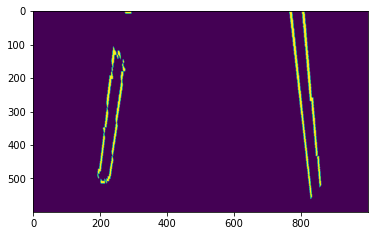

In [44]:
edges_projected = project_image(edges)
plt.imshow(edges_projected)

In [45]:
edges_projected.max()

255

## 3. Hough Transformation + Line Masking

대충 설명하면 다음과 같다.

1) Hough Transformation을 통해 edge image에서 매칭될 수 있는 선분의 집합을 찾는다. 각 선분은 시작점 (x1, y1)과 끝점 (x2, y2)의 집합으로 표현된다.
2) 위 edge image를 보면 알 수 있듯이, 대부분의 차선은 y축과 평행한 방향에 가깝다. 즉 기울기의 절댓값이 매우 크다는 뜻이므로, 기울기의 절댓값이 크지 않은 선분들은 선분 집합에서 버린다.
3) 이렇게 얻은 선분 집합을 토대로 마스킹을 다시 한다.

이렇게 하면 전체 edge 중 차선이 아닐 것 같아 보이는 것들은 일단 거를 수 있다.

In [46]:
def mask_line(edges, thickness=5):
    # If there are no lines to draw, exit.
    lines = cv2.HoughLinesP(
        edges,
        rho=6,
        theta=np.pi / 60,
        threshold=160,
        lines=np.array([]),
        minLineLength=40,
        maxLineGap=25
    )

    lines_filtered = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2:
                continue
            slope = (y2 - y1) / (x2 - x1)
            if abs(slope) < 2.0:
                continue
            lines_filtered.append(line)

    # Make a copy of the original image.
    line_img = np.zeros_like(edges)
    # Create a blank image that matches the original in size.
    # Loop over all lines and draw them on the blank image.
    for line in lines_filtered:
        for x1, y1, x2, y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), [255, 255, 255], thickness)

    line_img = (line_img >= 127).astype(np.uint8) * 255

    return line_img

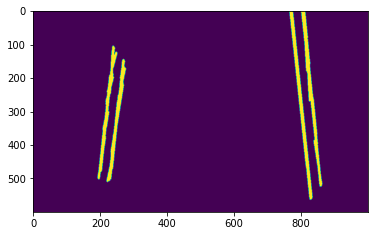

In [47]:
line_mask = mask_line(edges_projected)
plt.imshow(line_mask)

## 4. Line Fitting 2차함수 계수 구하기

일단 위에서 구한 masking을 왼쪽과 오른쪽으로 찣어두고 각각에서 구하자.

In [48]:
left_mask = np.zeros_like(edges_projected)
right_mask = np.zeros_like(edges_projected)

left_mask[:, :500] = line_mask[:, :500]
right_mask[:, 500:] = line_mask[:, 500:]

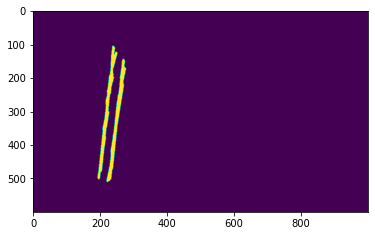

In [49]:
plt.imshow(left_mask)

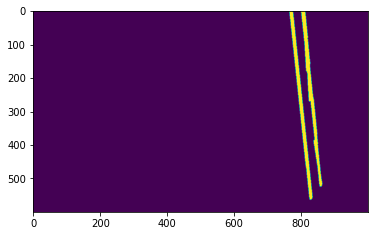

In [50]:
plt.imshow(right_mask)

가장 단순무식한 방법은 그냥 MSE estimator를 갖다 쓰는 것이다. 그런데 이렇게 하면 지금 경우에서 왼쪽 차선은 별 문제가 없겠지만, 오른쪽 차선은 위쪽 구석탱이에 차선이 아닌데 edge로 인식된 무언가 때문에 단순한 MSE가 안 된다. Robust estimator 중에 좀 쉽게 구현 가능해 보이는 M-estimator with IRLS를 사용했다. M-estimator와 IRLS가 뭔지는 위키백과를 보자.

https://en.wikipedia.org/wiki/M-estimator

https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares 

함수의 return값 중 lane_fitx는 곡선으로 표현된 차선에서 y좌표가 0, 1, 2, ... 일 때 각각의 x좌표를 나타낸 것이고, fit은 2차함수의 계수를 의미한다. 이걸 실제로 써먹을 때에는 2차함수 계수보다는 실제 좌표값이 더 중요하긴 한데, 뭐 그냥 그렇다고...

In [51]:
# polynomial fit with m-estimator with IRLS instead of least squares
def fit_from_lines(mask, s_coeff=1.0):
    y, x = np.nonzero(mask)
    fit = np.polyfit(y, x, 2)

    ploty = np.linspace(0, mask.shape[0] - 1, mask.shape[0])
    lane_fitx = fit[0] * ploty ** 2 + fit[1] * ploty + fit[2]

    # M-estimator
    residuals = x - (fit[0] * y ** 2 + fit[1] * y + fit[2])
    median = np.median(residuals)
    deviation = np.abs(residuals - median)
    mdev = np.median(deviation)
    
    s = s_coeff * mdev
    mask = deviation < 2.0 * s

    y = y[mask]
    x = x[mask]
    fit = np.polyfit(y, x, 2)
    lane_fitx = fit[0] * ploty ** 2 + fit[1] * ploty + fit[2]

    return lane_fitx, fit

left_fitx, left_fit = fit_from_lines(left_mask)
right_fitx, right_fit = fit_from_lines(right_mask)

In [52]:
right_fitx[:10]

array([787.21263046, 787.33926327, 787.46575879, 787.59211703,
       787.71833797, 787.84442163, 787.97036799, 788.09617707,
       788.22184886, 788.34738336])

슬라이딩 윈도우인가 뭔가도 한 번 써보자

In [53]:
# Sliding window search
def sliding_windown(img_w, left_or_right, debug=False):
    histogram = np.sum(img_w[int(img_w.shape[0] / 2):, :], axis=0)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img_w, img_w, img_w)) * 255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] / 2)

    if left_or_right == 'left':
        lane_base = np.argmax(histogram[:midpoint])
    elif left_or_right == 'right':
        lane_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 20

    # Set height of windows
    window_height = np.int(img_w.shape[0] / nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img_w.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    x_current = lane_base

    # Set the width of the windows +/- margin
    margin = 50

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive lane pixel indices
    lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y
        win_y_low = img_w.shape[0] - (window + 1) * window_height
        win_y_high = img_w.shape[0] - window * window_height
        win_x_low = x_current - margin
        win_x_high = x_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_x_low, win_y_low), (win_x_high, win_y_high), (0, 255, 0), 2)
        cv2.circle(out_img, (x_current, (win_y_low + win_y_high) // 2), 5, (255, 0, 0), -1)

        # Identify the nonzero pixels in x and y within the window
        good_lane_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_x_low) & (
            nonzerox < win_x_high)).nonzero()[0]

        # Append these indices to the lists
        lane_inds.append(good_lane_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_lane_inds) > minpix:
            x_current = np.int(np.mean(nonzerox[good_lane_inds]))

    # Concatenate the arrays of indices
    lane_inds = np.concatenate(lane_inds)

    # Extract line pixel positions
    x = nonzerox[lane_inds]
    y = nonzeroy[lane_inds]

    # Fit a second order polynomial to each
    lane_fit = np.polyfit(y, x, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img_w.shape[0] - 1, img_w.shape[0])
    lane_fitx = lane_fit[0] * ploty ** 2 + lane_fit[1] * ploty + lane_fit[2]
    
    if debug:
        return lane_fitx, lane_fit, out_img
    return lane_fitx, lane_fit

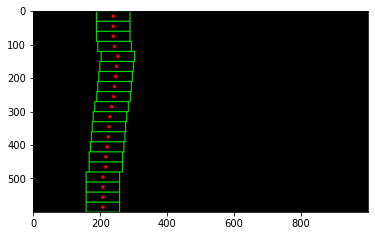

In [54]:
left_fitx, left_fit, out_img = sliding_windown(left_mask, 'left', debug=True)
plt.imshow(out_img)

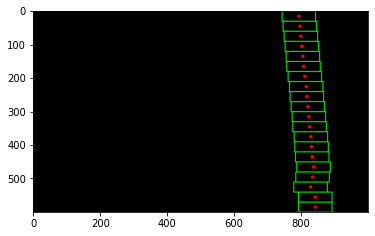

In [55]:
right_fitx, right_fit, out_img = sliding_windown(right_mask, 'right', debug=True)
plt.imshow(out_img) 

이 아래는 시각화를 위한 뻘짓이다. 사실 이걸 그대로 ROS node 코드에다가 써먹을 수 있는 것도 아니고, ROS node(`/turtlebot3_autorace_detect/lane_detect_new`)도 따로 완성해 놨으니까 이 다음 단계로 뭘 하는지 궁금하면 거길 보자.

In [56]:
final_line_mask = np.zeros_like(edges_projected)
pts_left = np.array([np.transpose(np.vstack([left_fitx, np.linspace(0, final_line_mask.shape[0] - 1, final_line_mask.shape[0])]))])
pts_right = np.array([np.transpose(np.vstack([right_fitx, np.linspace(0, final_line_mask.shape[0] - 1, final_line_mask.shape[0])]))])

centerx = (left_fitx + right_fitx) / 2
pts_center = np.array([np.transpose(np.vstack([centerx, np.linspace(0, final_line_mask.shape[0] - 1, final_line_mask.shape[0])]))])

pts = np.hstack((pts_left, pts_right, pts_center))

cv2.polylines(
    final_line_mask,
    np.int_([pts_left]),
    isClosed=False,
    color=(255, 255, 255),
    thickness=5
)
cv2.polylines(
    final_line_mask,
    np.int_([pts_right]),
    isClosed=False,
    color=(255, 255, 255),
    thickness=5
)
cv2.polylines(
    final_line_mask,
    np.int_([pts_center]),
    isClosed=False,
    color=(255, 255, 255),
    thickness=5
)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [57]:
pts_center

array([[[521.60349663,   0.        ],
        [521.65333288,   1.        ],
        [521.70298497,   2.        ],
        ...,
        [518.59166612, 597.        ],
        [518.53155582, 598.        ],
        [518.47126135, 599.        ]]])

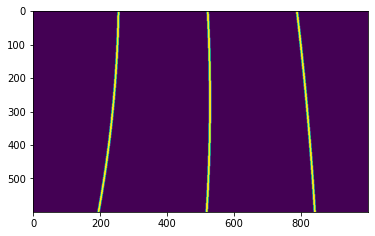

In [58]:
plt.imshow(final_line_mask)

In [ ]:
# remove the misleading lines (in step 3)
# using the polynomial fit
# if the line is too far from the polynomial fit, remove it
def remove_misleading_lines(mask, left_fitx, right_fitx, margin=50):
    y, x = np.nonzero(mask)
    lane_center = (left_fitx + right_fitx) / 2

    mask = np.abs(x - (lane_center[y])) < margin

    y = y[mask]
    x = x[mask]

    return y, x

In [ ]:
# now we need to distinguish if the line is dash or solid
# for each line (left and light), find the count of rows that have white pixels
# if the count is less than a threshold, then it is a dash line
def find_dash_line(mask, threshold=None):
    if threshold is None:
        # ok this will need lots of tuning
        threshold = int(mask.shape[1] * 0.7)
    dash = False
    white_rows = np.sum(mask == 255, axis=1)
    if np.sum(white_rows < threshold) > 0:
        dash = True
    return dash